vectorized env does not appear to learn. testing on cartpole

In [1]:
import os
KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ  # detect if notebook is running on Kaggle
if KAGGLE:
    !pip install gymnasium[atari]==1.1.0

In [2]:
from gymnasium.wrappers import Autoreset, TimeAwareObservation, FrameStackObservation, AtariPreprocessing, ClipReward
from collections import defaultdict, deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
import ale_py
import wandb
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
print(gym.__version__, torch.__version__, torch.get_num_threads(), torch.get_num_interop_threads(), sep='\n')

1.1.0
2.6.0+cpu
10
10


In [4]:
# globals
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env_name = 'CartPole-v1'

In [5]:
def make_env(render_mode=None):
    env = gym.make(env_name, render_mode=render_mode, max_episode_steps=500)
    # env = TimeAwareObservation(env)
    env = ClipReward(env, -1, 1)
    return env

In [6]:
def make_envs(n_envs=32):  # >32 might cause memory issues
    envs = gym.make_vec(
        env_name, 
        max_episode_steps=500,
        num_envs=n_envs, 
        vectorization_mode='async', 
        vector_kwargs={
            # 'autoreset_mode': gym.vector.AutoresetMode.DISABLED,
        },
        wrappers=[  # make_vec autoresets by default
            lambda env: ClipReward(env, -1, 1),
        ]
    )
    return envs

In [109]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(4, 64), 
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU()
        )        
        self.policy_head = nn.Linear(64, 2)
        self.value_head = nn.Linear(64, 1)

    @staticmethod
    def preprocess(x):
        if len(x.size()) == 1:
            x = x.unsqueeze(0)  # add the batch dim
        with torch.no_grad():
            # x = x / 255.0  # should we scale to [0, 1]
            x *= 1
        x.requires_grad_()
        return x

    def value_only(self, x):
        x = self.preprocess(x)
        x = self.backbone(x)
        value = self.value_head(x)
        return value
        
    def forward(self, x):
        x = self.preprocess(x)
        x = self.backbone(x)
        logits = self.policy_head(x)
        value = self.value_head(x)
        
        return logits, value

    def sample(self, state, stochastic=True):
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        if stochastic:
            action = dist.sample()
        else:
            action = torch.argmax(logits, dim=-1)
        log_prob = dist.log_prob(action)
        
        return action, log_prob, value
        

In [111]:
def scope():  # check env is set up correctly
    e = make_env()
    e.reset()
    for i in range(500):
        if i % 10 == 0:
            clear_output(wait=True)
        s, r, term, trunc, _ = e.step(e.action_space.sample())
        print('iter', i, (r,term,trunc))
        if term or trunc:
            sout = ''
            if term: sout += 'terminated'
            if trunc: sout += 'truncated'  # truncates at max_episode_steps
            print(sout)
    e.close()
# scope()

In [112]:
@torch.no_grad()
def collect_rollout(envs, network: ActorCritic, min_steps):
    min_steps /= envs.num_envs
    state = torch.as_tensor(envs.reset()[0], dtype=torch.float).to(device)
    states, actions, rewards, terminateds, truncateds, log_probs, values = [], [], [], [], [], [], []
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state)
        next_state, reward, terminated, truncated, _ = envs.step(action.numpy().squeeze())
        next_state = torch.as_tensor(next_state, dtype=torch.float).to(device)
        reward = torch.as_tensor(reward, dtype=torch.float)
        terminated = torch.as_tensor(terminated, dtype=torch.float)
        truncated = torch.as_tensor(truncated, dtype=torch.float)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        terminateds.append(terminated)
        truncateds.append(truncated)
        log_probs.append(log_prob)
        values.append(value)
        state = next_state
        if step >= min_steps and (terminated.any() or truncated.any()):
            break
    values.append(network.value_only(state))  # add the last value
    
    states = torch.stack(states, 1)                             # [n_envs, T, 4,84,84]
    actions = torch.stack(actions, 1)                           # [n_envs, T]
    rewards = torch.stack(rewards, 1).to(device)
    terminateds = torch.stack(terminateds, 1).to(device)
    truncateds = torch.stack(truncateds, 1).to(device)
    values = torch.stack(values, 1).squeeze()                   # [n_envs, T+1]
    log_probs = torch.stack(log_probs, 1)
    truncateds[:,-1] = 1  # set truncation flag
    
    return states, actions, rewards, terminateds, truncateds, log_probs, values

In [113]:
@torch.no_grad()
def evaluate(network: ActorCritic, stochastic=False, render_mode=None, graph=False):
    _env = make_env(render_mode)
    state = torch.as_tensor(_env.reset()[0], dtype=torch.float).to(device)
    sum_rewards = 0
    if graph:
        values = []
        immediate_reward = []
        rewards_collected = []
        values_plus_rewards = []
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state, stochastic=stochastic)
        next_state, reward, terminated, truncated, _ = _env.step(action.numpy().squeeze())
        sum_rewards += reward
        if graph:
            values += [value.item()]
            immediate_reward += [reward]
            rewards_collected += [sum_rewards]
            values_plus_rewards += [value.item() + sum_rewards - reward]
            if step % 20 == 0 or terminated or truncated:
                plt.plot(values, label='values')
                plt.plot(immediate_reward, label='immediate reward')
                plt.plot(rewards_collected, label='rewards collected')
                plt.plot(values_plus_rewards, label='rewards + values')
                plt.legend()
                clear_output(wait=True)
                plt.show()
        state = torch.as_tensor(next_state, dtype=torch.float).to(device)
        if terminated or truncated:
            break
    _env.close()
    return sum_rewards

In [123]:
@torch.no_grad()
def gae(rewards, terminateds, truncateds, values, gamma, lambda_):
    # assert not (truncateds[:,:-1].any())  # for now, assume only truncation is the last step
    td_errors = rewards + gamma * values[:,1:] * (1 - terminateds) - values[:,:-1]  # on truncation bootstrap from the next value
    advantages = torch.zeros_like(td_errors)
    advantage = torch.zeros_like(td_errors[:,0])
    for t in reversed(range(td_errors.size(1))):
        advantage = lambda_ * gamma * advantage * (1 - terminateds[:,t]) + td_errors[:,t]
        advantages[:,t] = advantage
    return advantages

In [115]:
def explained_variance(returns, values):  # measure of critic's accuracy: 0 = random guessing, 1 = perfect
    var_returns = torch.var(returns)
    var_residuals = torch.var(returns - values)
    if var_returns == 0: return 0.0 if var_residuals == 0 else -float('inf')
    return (1 - var_residuals / var_returns).item()

In [116]:
batch_size = 512
num_steps = 4096  # steps per rollout
num_epochs = 10   # epochs per iteration
gae_lambda = 0.95      # GAE(lambda): 0 is same as TD-error, 1 is same as Monte Carlo return
value_weight = 0.5     # weight of value loss (vs policy loss)
entropy_bonus = 0.01 * 1.0  # entropy regularization coefficient in loss, may need to manually adjust with reward scale
clip_eps = 0.2         # policy ratio clipping radius
clip_eps_value = None   # value clipping radius
gamma = 0.99
policy_lr = 3e-4
value_lr = 1e-3
backbone_lr = 3e-4  # lr for the shared backbone, OpenAI's Spinning Up implicity uses same lr as critic
max_norm = 0.5

checkpoint_freq = 40
eval_freq = 2

# policy_lr *= 100
# value_lr *= 100
# backbone_lr *= 100

In [130]:
p = 3
def f():
    _p = p
f()

In [117]:
# try: envs.reset(), envs.close()
# except: pass
# envs = make_envs()

network = ActorCritic().to(device)

# if compiling
# import cl_fix
# network = torch.compile(network)

shared_backbone_params = list(network.backbone.parameters())
policy_head_params = list(network.policy_head.parameters())
value_head_params = list(network.value_head.parameters())

optimizer = torch.optim.Adam([  # single optimizer, avoids ambiguity in lr of backbone that is present in Spinning Up
    {'params': policy_head_params, 'lr': policy_lr},
    {'params': value_head_params, 'lr': value_lr},
    {'params': shared_backbone_params, 'lr': backbone_lr},
])

wandb.login(key='764fe2985db37b03500e798e1a8ea9ad359f81ec')
wandb.finish()
wandb.init(
    project='PPO-' + env_name.replace('/', '_'),
    name='vec' + (' (Kaggle)' if KAGGLE else ''),
    # mode='disabled',
    config={
        'batch_size': batch_size,
        'num_steps': num_steps,
        'num_epochs': num_epochs,
        'max_norm': max_norm,
        'gae_lambda': gae_lambda,
        'value_weight': value_weight,
        'entropy_bonus': entropy_bonus,
        'clip_eps': clip_eps,
        'clip_eps_value': clip_eps_value,
        'gamma': gamma,
        'policy_lr': policy_lr,
        'value_lr': value_lr,
        'backbone_lr': backbone_lr,
        'env_name': env_name,
        'device': device,
    }
)

history = {'step_count': 0}

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


advantage,▄█▇▇▆▇▇▄▆▆▇▅▅▄▄▇█▃▆▇▅▄█▅▅▅▄▂█▅▁▅▄▇▃▃▁▅▄▄
approx_fps,▄▇█▆▅▄▁▃▂▃▅▅▆▄▂▅▅▄▂▆▅▄▆▅▅▅▁▃▂▃▅▃▅▆▅▅▅▅▅▅
approx_kl,▅▃▁▁▂▂▃▂▃▂▁▃▂▁▁▁▃▆▁▁▁▁▁▄▄▃▁▁▁▃▁▂▆▂▂▆██▅▆
clip_fraction,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▆▁▁▃█▆▆▆
entropy,▅▆▆███▇▆▆▅▆▆▆███▅▅▇██▅█▅▅▃▇▇▇▇▅▆▄▇▇▃▄▁▄▅
eval_rewards (deterministic),▃▂▄▂▃▂▃▃▁▃▃▅▂▂▃▂▄▁█▄▁▃
eval_rewards (stochastic),▄▅▂▂▂█▃▂▄▂▁▂▄▃▃▂▁▄▂▂▁▂
eval_time,▃▃▂▁▁▆▃▁▃▂▁▂▃█▃▂▁▃▂▂▁▂
explained_variance,▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▇▆█▇▅▆▆▇▅▇▇█▁▇▂▂▁▄█
global_l2_norm,▃▅▃▁▄▃▂▂▃▂▃▃▂▃▂▁▂▄▃▁▁▄▂▃▃▄▄▃▃▄▂▅▅▃▃▅▇▇██
loss_cum,▃▆▄▄█▁▄▄▃▄▃▃▄▃▆▄▄▃▃▄▄▂▄▄▅▂▄▄▅▂▃▄▃▃▃▂▃▃▃▂


In [118]:
def save(network, history):
    pass

In [119]:
def load(network, optimizer, history, path):
    data = torch.load(path, weights_only=False, map_location=torch.device(device))
    network.load_state_dict(data['network_state_dict'])
    optimizer.load_state_dict(data['optimizer_state_dict'])
    history.update(data['history'])
    print('loaded from ' + path)

In [124]:
def train(envs, num_updates, history):
    t_start = time.time()
    try:
        for update in range(1, num_updates+1):
            if update % checkpoint_freq == 0:
                save(network, history)
            
            t0 = time.time()
            states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(envs, network, num_steps) 
            rollout_time = time.time() - t0
            
            t0 = time.time()
            gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
            values = values[:,:-1]  # remove the last values after gae
            advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)  # careful with standardization
            
            advantages = advantages.ravel()
            values = values.ravel()
            log_probs = log_probs.ravel()
            actions = actions.ravel()
            states = states.reshape(-1, *states.shape[2:])
            assert advantages.size(0) == values.size(0) == log_probs.size(0) == actions.size(0) == states.size(0)
            
            returns = advantages + values
            actual_steps = states.size(0)            
            
            # stats across all minibatches
            mb_policy_losses = []
            mb_value_losses = []
            mb_entropies = []
            mb_kls = []
            mb_clip_fractions = []
            mb_global_l2_norms = []
            
            for _ in range(num_epochs):
                indices = torch.randperm(actual_steps)
                for begin in range(0, actual_steps, batch_size):
                    end = begin + batch_size
                    batch_indices = indices[begin:end]
                    
                    states_b = states[batch_indices]
                    actions_b = actions[batch_indices]
                    returns_b = returns[batch_indices]
                    advantages_b = advantages[batch_indices]
                    old_log_probs = log_probs[batch_indices]
                    
                    logits, values_b = network(states_b)
                    values_b = values_b.squeeze()
                    dist = Categorical(logits=logits)
                    entropy = dist.entropy().mean()
                    cur_log_probs = dist.log_prob(actions_b.squeeze()).reshape(old_log_probs.shape)
                
                    # policy loss
                    ratio = torch.exp(cur_log_probs - old_log_probs)  # same as cur_probs/old_probs, just with logs
                    fst_surrogate = ratio * advantages_b
                    snd_surrogate = torch.clip(ratio, 1 - clip_eps, 1 + clip_eps) * advantages_b
                    policy_loss = -torch.min(fst_surrogate, snd_surrogate).mean() - entropy_bonus * entropy
                    
                    # value loss
                    if clip_eps_value is not None:
                        old_values_b = values[batch_indices]
                        values_clipped = old_values_b + (values_b - old_values_b).clip(-clip_eps_value, clip_eps_value)
                        fst_loss = F.huber_loss(values_clipped, returns_b, reduction='none')
                        snd_loss = F.huber_loss(values_b, returns_b, reduction='none')
                        value_loss = value_weight * torch.max(fst_loss, snd_loss).mean()  # take the more conservative one
                    else:
                        value_loss = value_weight * F.huber_loss(values_b, returns_b, reduction='mean')
    
                    cum_loss = policy_loss + value_loss
                    optimizer.zero_grad()
                    cum_loss.backward()
                    global_l2_norm = nn.utils.clip_grad_norm_(network.parameters(), max_norm)
                    optimizer.step()
                    
                    # Track statistics for this minibatch
                    mb_policy_losses.append(policy_loss.item())
                    mb_value_losses.append(value_loss.item())
                    mb_entropies.append(entropy.item())
                    mb_kls.append((old_log_probs - cur_log_probs).mean().item())
                    clip_fraction = ((ratio > 1 + clip_eps) | (ratio < 1 - clip_eps)).float().mean().item()
                    mb_clip_fractions.append(clip_fraction)
                    mb_global_l2_norms.append(global_l2_norm)
                    
            # average stats across minibatches
            avg_policy_loss = sum(mb_policy_losses) / len(mb_policy_losses)
            avg_value_loss = sum(mb_value_losses) / len(mb_value_losses)
            avg_entropy = sum(mb_entropies) / len(mb_entropies)
            avg_kl = sum(mb_kls) / len(mb_kls)
            avg_clip_fraction = sum(mb_clip_fractions) / len(mb_clip_fractions)
            avg_global_l2_norm = sum(mb_global_l2_norms) / len(mb_global_l2_norms)
            
            history['step_count'] += actual_steps        
            
            update_time = time.time() - t0
            wall_time = time.time() - t_start
    
            t0 = time.time()
            with torch.no_grad():
                exp_var = explained_variance(returns, values)
            stats_time = time.time() - t0
                
            log = {
                'entropy': avg_entropy,
                'explained_variance': exp_var,
                'loss_policy': avg_policy_loss,  # entropy bonus incl.
                'loss_value': avg_value_loss,
                'loss_entropy': -entropy_bonus * avg_entropy,
                'loss_cum': avg_policy_loss + avg_value_loss,
                'approx_kl': avg_kl,  # average across all minibatches
                'clip_fraction': avg_clip_fraction,  # (policy ratio)
                'global_l2_norm': avg_global_l2_norm,
                'advantage': gae_advantages.mean().item(),  # pre standardization
                'update': update,
                'step_count': history['step_count'],
                'approx_fps': actual_steps / (update_time + rollout_time),
                'time_wall': wall_time,
                'time_update': update_time,
                'time_rollout': rollout_time,
                'time_stats': stats_time,
            }
    
            if update % eval_freq == 0 or update == num_updates:
                t0 = time.time()
                eval_rewards_d = evaluate(network, stochastic=False)
                eval_rewards_s = evaluate(network, stochastic=True)
                eval_time = time.time() - t0
                log.update({
                    'eval_time': eval_time,
                    'eval_rewards (deterministic)': eval_rewards_d,
                    'eval_rewards (stochastic)': eval_rewards_s,
                })
    
                clear_output(wait=True)
                print(f'wall time {wall_time:.2f} s')
                print(f'update {update}')
                print(f'step {history["step_count"]}')
                print(f'eval rewards (deterministic) {eval_rewards_d:.5f}')
                print(f'eval rewards (stochastic) {eval_rewards_s:.5f}')
    
            try: wandb.log(log, step=history['step_count'])
            except: print(f'[warning] wandb log failed')

    except KeyboardInterrupt:
        save(network, history)

In [125]:
# load(network, optimizer, history, './saved/breakout-10786461s.pth')

In [126]:
if KAGGLE:
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)

try: envs.reset(), envs.close()
except: pass
envs = make_envs(8)

t0 = time.time()
try:
    with torch.device(device):
        train(envs, 999999, history)
except KeyboardInterrupt:
        print('keyboard interrupt. stopping...')
finally:
    print(f'done.\n*actual* time taken: {time.time() - t0:.2f} s')

wall time 140.83 s
update 24
step 223040
eval rewards (deterministic) 500.00000
eval rewards (stochastic) 500.00000
done.
*actual* time taken: 146.57 s


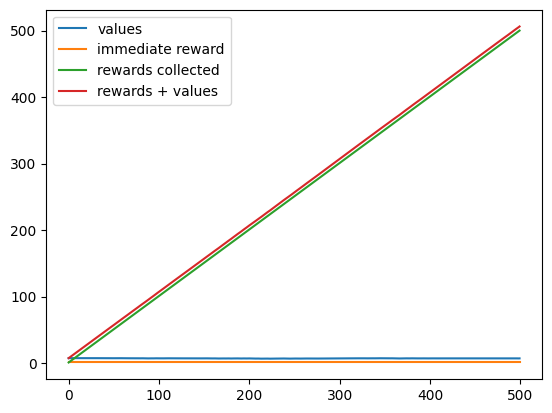

np.float64(500.0)

In [127]:
evaluate(network, stochastic=True, render_mode='human', graph=True)

# ahhhhhhhh

In [80]:
states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(envs, network, num_steps) 

gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
values = values[:,:-1]  # remove the last values after gae
advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)  # careful with standardization

advantages = advantages.ravel()
values = values.ravel()
log_probs = log_probs.ravel()
actions = actions.ravel()
states = states.reshape(-1, *states.shape[2:])
assert advantages.size(0) == values.size(0) == log_probs.size(0) == actions.size(0) == states.size(0)

returns = advantages + values

In [81]:
log_probs.shape

torch.Size([4152])

In [82]:
actual_steps = states.size(0)            

# stats across all minibatches
mb_policy_losses = []
mb_value_losses = []
mb_entropies = []
mb_kls = []
mb_clip_fractions = []
mb_global_l2_norms = []

for _ in range(num_epochs):
    indices = torch.randperm(actual_steps)
    for begin in range(0, actual_steps, batch_size):
        end = begin + batch_size
        batch_indices = indices[begin:end]

        states_b = states[batch_indices]
        actions_b = actions[batch_indices]
        returns_b = returns[batch_indices]
        advantages_b = advantages[batch_indices]
        old_log_probs = log_probs[batch_indices]

        logits, values_b = network(states_b)
        values_b = values_b.squeeze()
        dist = Categorical(logits=logits)
        entropy = dist.entropy().mean()
        cur_log_probs = dist.log_prob(actions_b.squeeze()).reshape(old_log_probs.shape)

        # policy loss
        ratio = torch.exp(cur_log_probs - old_log_probs)  # same as cur_probs/old_probs, just with logs
        fst_surrogate = ratio * advantages_b
        snd_surrogate = torch.clip(ratio, 1 - clip_eps, 1 + clip_eps) * advantages_b
        policy_loss = -torch.min(fst_surrogate, snd_surrogate).mean() - entropy_bonus * entropy
        
        # value loss
        if clip_eps_value is not None:
            old_values_b = values[batch_indices]
            values_clipped = old_values_b + (values_b - old_values_b).clip(-clip_eps_value, clip_eps_value)
            fst_loss = F.huber_loss(values_clipped, returns_b, reduction='none')
            snd_loss = F.huber_loss(values_b, returns_b, reduction='none')
            value_loss = value_weight * torch.max(fst_loss, snd_loss).mean()  # take the more conservative one
        else:
            value_loss = value_weight * F.huber_loss(values_b, returns_b, reduction='mean')

        cum_loss = policy_loss + value_loss
        optimizer.zero_grad()
        cum_loss.backward()
        global_l2_norm = nn.utils.clip_grad_norm_(network.parameters(), max_norm)
        optimizer.step()

In [92]:
dist.log_prob(actions_b).shape

torch.Size([56])

In [93]:
values_b

tensor([0.7140, 0.7082, 0.7414, 0.7160, 0.6996, 0.7130, 0.7157, 0.7296, 0.7022,
        0.7278, 0.6954, 0.7054, 0.7251, 0.7129, 0.7058, 0.7071, 0.6954, 0.7389,
        0.7075, 0.7357, 0.7421, 0.7069, 0.6808, 0.7017, 0.7047, 0.7172, 0.6915,
        0.6922, 0.7076, 0.7128, 0.6924, 0.7085, 0.7233, 0.7212, 0.6994, 0.7249,
        0.6819, 0.7249, 0.7087, 0.7121, 0.7017, 0.7200, 0.7220, 0.7141, 0.7066,
        0.7074, 0.7086, 0.7191, 0.7034, 0.7074, 0.7163, 0.7078, 0.7291, 0.6943,
        0.7004, 0.7085], grad_fn=<SqueezeBackward0>)

In [94]:
returns_b

tensor([-0.4697,  1.9162, -0.8662, -0.0938,  1.2915,  1.4707, -0.4681, -0.2622,
         1.6101,  1.3190,  2.0041,  1.3821, -1.1125,  1.4735,  1.3001,  1.9153,
        -1.1394, -0.0722,  2.1759, -1.1029,  0.6911,  2.3989, -0.3089,  1.2927,
        -0.3419,  0.5301, -0.1185,  0.6366,  0.8935,  1.5496, -0.2986,  2.5859,
         0.0833,  1.5554, -1.1358, -0.4591, -0.1273, -1.1127,  0.2286,  1.3020,
         1.4610, -0.2710,  0.2420,  1.2113,  2.1001,  1.5451,  0.8969,  2.2205,
         1.4646,  0.0675, -0.9516,  1.0077,  0.7865,  0.6378,  1.1024,  1.4665])